The goal of this code was to be a platform for background removal from samples focusing on datasets such as FTIR and XRD 

The logic behind this is that these kinds of data sets have intensity-reduced backgrounds or backgrounds where we expect the shape of the substrate or background to remain, but the intensity relitive to the sample to change. 

This is particularly useful for XRD and FTIR as these detect specific information such as crystal phase and relitive bond intensity. weighted by the amount of the reading. meaning that while we expect a sample to have reduced background intensity compared to a blank background sample we can use information from this blank background sample to adjsut and analyse our other samples. 

this is done by striping the data removing information that is unlikely to be from the background and finding the average relative intensity between the remaining information. from there we can adjust and remove the background in order to extract only the sample information. 

This method allows for a much greater depth of analysis allowing for examination of the true spectrum of a material while allowing for comparisons across differnt kinds of substrate or background not usually possible with these techniques. 

The structure of this document is as follows:

Imports and file selection: This section allows you to load in the files you will be using for data analysis, specifying one file for your sample and another for your background or substrate data. this code must be run 

function defintion: This contains the various functions used throughout the code. This cell must be run in order to define various functions used later

test cells:
These cells allow you to play around with some functions, seeing there specific functionality. These are optionals and dont need to be fun, but may give some insight into how the function is working and show how these can be used individually. 

final run:
This is the intended final code, which deals with importing. If you wish to run the code and get appropriate results, first run the import cell [cell 3] followed by the function definition cell [cell 4]. You can then move to this final cell, specify the variables listed at the top of the function and the kind of data being used, and run to receive your results. which will result in the following data
-background scalar
-final root mean squared error 
-subplot of background and data 
-graph of final residuals and linier fit
-background corrected data 
-list of peaks (optional)
-file output (optional)

In [3]:
#imports
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

#a section for ignoring warnings which is ment to improve readability as scipy and pandas are passing warning for things the code acconuts for 
import warnings
warnings.filterwarnings('ignore')

#Variable selection
data_file = "testdata2.csv" # The data file this should contain your data for your sample on a substrate or in a background and should be a .CSV file with 2 columbs x and y data
background_file = "testdata2background.csv"# The data file this should contain your data for your sample on a substrate or in a background and should be a .CSV file with 2 columbs x and y data
data_header = 1 # Please specify how many lines precede the data in this file. This may include headers or information about the sample collection method
background_header = 1 # Please specify how many lines precede the data in the background file. This may include headers or information about the sample collection method

data = pd.read_csv(data_file,skiprows=data_header,header = None)
background = pd.read_csv(background_file,skiprows=background_header,header = None)
print(data)

               0         1
0     3995.86982  0.024725
1     3993.94131  0.023681
2     3992.01281  0.022775
3     3990.08430  0.022608
4     3988.15579  0.022850
...          ...       ...
1654   806.11660  0.016928
1655   804.18809  0.016800
1656   802.25958  0.016800
1657   800.33107  0.016600
1658   798.40256  0.016232

[1659 rows x 2 columns]


In [6]:
def peakfind(dataset,*args,dir=1,area=[-1000000,1000000],min=.001,minslope=.001):
    index = 0
    inpeak= 0 
    peaklist = [[0,0],[0,0]]##formats what the peak list is supposed to look like 
    peak_count = 0
    for x in dataset[1]:
        if dataset[0][index] > area[0] and dataset[0][index] < area[1] and index+1 < len(dataset[1]): 
            if x*dir < dir*dataset[1][index+1] and index+3 < len(dataset[1]):
                if dir*dataset[1][index+1] < dir*dataset[1][index+2] and dir*dataset[1][index+2] < dir*dataset[1][index+3] and np.abs(dataset[1][index+3]-x)> minslope and x > min :
                    if inpeak != 1:
                        inpeak = 1
                        peak_count += 1 
            elif inpeak == 1:##if we are currently in a peak but the next point is not bigger we have reached the maximum and want to save the point
                peaklist.append([dataset[0][index],dataset[1][index]])
                inpeak = 0
            else:
                inpeak = 0
            index +=1
        else:
            index +=1
    print("there are " + str(peak_count) + " peaks at the points: ")
    #print(peaklist)
    peaklist.pop(0)##removes the two erroneous 0,0 points we added to format the peak list. 
    peaklist.pop(0)
    return(peaklist)

def findsigdata (datain, minimum, *args, range=[-1000000,1000000],dif=1):
    index = 0 
    sigdata = pd.DataFrame(columns=['x', 'y', 'index'])
    for x in datain[1]:
        if x > minimum and datain[0][index] > range[0] and datain[0][index] < range[1]: 
            sigdata = pd.concat([sigdata,pd.DataFrame({"x":[datain[0][index]],"y":[x],"index":[index]})])
        index += 1
    sigdata.reset_index(drop=True, inplace=True)
   ## print(sigdata)
   ## plt.plot(sigdata["x"],sigdata["y"],"o")
    return(sigdata)

def linierfit(x,m,c):
    return m*x + c

def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions - targets)**2))

def extractnull(dataset):
    index = 0
    sigdata = pd.DataFrame(columns=['x', 'y', 'index'])
    for x in dataset["y"]: 
        if x != -.001:
            sigdata = pd.concat([sigdata,pd.DataFrame({"x":[dataset["x"][index]],"y":[x],"index":[dataset["index"][index]]})])
        index +=1
    sigdata.reset_index(drop=True, inplace=True)
    return sigdata

def linierfit(x,m,c):
    return m*x + c

def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions - targets)**2))

def linierscale(dataset,background,maxerror,rang):
    error = 1
    escape = 0
    rvalues = [0,0]
    while error > maxerror and escape !=1:
        plt.cla()
        compvals = pd.DataFrame(columns=['x', 'y', 'index'])
        xindex = 0
        nindex = 0
        nfound = 0
        dataset = extractnull(dataset)
        for x in dataset["x"]:
            for n in background[0]:
                if x < n+rang and x>n-rang:
                    nfound = nindex
                nindex += 1
            #after we have potetnailly found an x value
            if nfound != 0: 
                y = dataset["y"][xindex]/background[1][nfound]
                compvals = pd.concat([compvals,pd.DataFrame({"x":[dataset["x"][xindex]],"y":[y],"index":[dataset["y"][xindex]]})])
            nfound=0
            nindex =0
            xindex += 1
        compvals.reset_index(drop=True, inplace=True)
        #now we need to preform a linier fit and see what values are off. 
        slope, intercept, r, p, std = linregress([compvals["x"]],[compvals["y"]])
        theoryvals = linierfit(compvals["x"],slope,intercept)
        plt.plot(compvals["x"],theoryvals,"o",label="scalar")
        plt.plot(compvals["x"],compvals["y"],"o",label="Sample to background ratio")
        plt.xlabel('Wave Number (nm-1)')
        plt.ylabel("Scalar Ratio")
        plt.title("Linier Regression")
        
       ## print(str(slope)+" "+str(intercept))
        #print(r)
        ## our fit has been preformed now we need to analye our values. see what residuals are off
        ##first its easiest to find the risiduals. 
        residuals = compvals["y"] - theoryvals 
        plt.plot(compvals["x"],residuals,"o",label="Residuals")
        aver = np.average(np.abs(residuals))
        rmserror = rmse(theoryvals,compvals["y"])
        plt.legend()
        indexred = 0
        for x in residuals: 
            if np.abs(x) > 2*aver:
                dataset.loc[indexred,"y"] = -.001
                dataset.loc[indexred,"x"] = -.001
                dataset.loc[indexred,"index"] = -.001
            indexred +=1 

        rvalues.append(r**2)
        ##ending unrelated stuff
        if error == rmserror: ##simple peice of code that triggers a break. this happens if the code reaches a point where the error is not decreasing and the code would simply repeat forever
            print("PLEASE NOTE ESCAPE WAS TRIGGERED THIS INDICATES THE PROGRAM REACHED A POINT WHERE IT COULD NO LONGER REDUCE THE RMSE VALUE BEFORE IT REACHED THE SET PERAMITER \n This may result in a poor fit please check the final RMSE value and consider it as a part of your results")
            escape = 1 
        error = rmserror
    print("The final root mean squared error is "+str(rmserror))
    return(intercept)

there are 29 peaks at the points: 


Text(0.5, 1.0, 'Peak Identification')

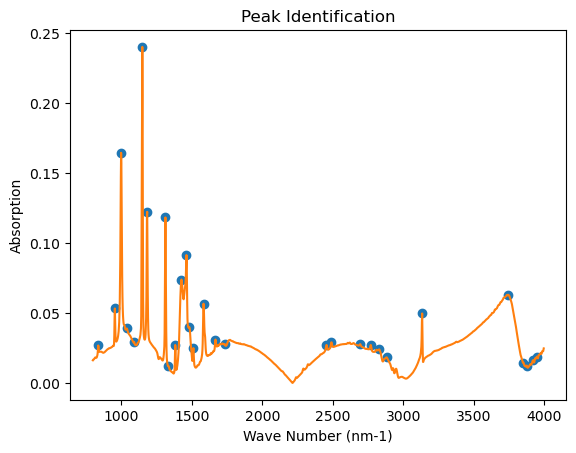

In [7]:
##function call peakfind an example of the peak finding code being used in order to identify 
peaklist = peakfind(data,dir=1,min=.01,minslope=.001)
##splitting x and y  values
x_points, y_points = zip(*peaklist)
##plotting the original data scales are omitted from this because its intended to function with a variety of data types
plt.plot(x_points,y_points,'o')
plt.plot(data[0],data[1])
#plt.plot(background[0],background[1])
plt.xlabel('Wave Number (nm-1)')
plt.ylabel("Absorption")
plt.title("Peak Identification")

Text(0.5, 1.0, 'signifigent peak data')

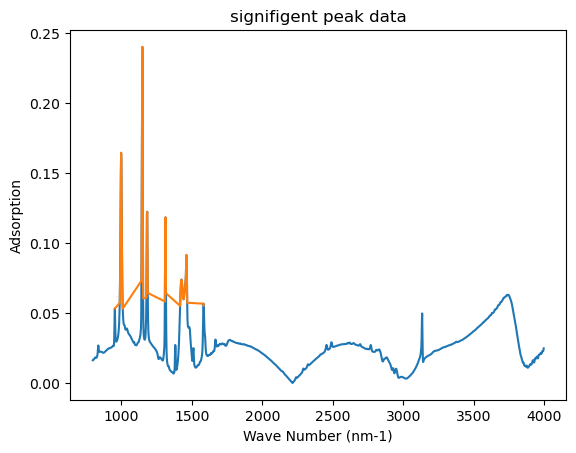

In [8]:
#this is a test cell showing the application of the findsigdata function which is used in order to identify data which may be relivent to the background
#when dealing with background data areas with extreamly low measurements can often have a negative impact on data as when you get down to very small data
#values the scalar ratio can be thrown off by even small bits of noise or areas which fall to 0 which can cause unintended division errors. 
#here we use sigdata to trunkate some data. removing an arent peak from the end of our data range while also eliminating the irregular humps lower in the range
sigdata = findsigdata(data,.05,range=[0,3500])
plt.plot(data[0],data[1])
plt.plot(sigdata['x'],sigdata['y'])
plt.xlabel('Wave Number (nm-1)')
plt.ylabel("Adsorption")
plt.title("signifigent peak data")
#as can be seen when compared to the normal data it highlights the specific areas which we expect may be relevant to either the background or the sample 
#however while this gives us a better idea of the relevant data it doesn't paint a whole picture as the background may still be shifting some of this data
#hence the need for the further techniques used here

The final root mean squared error is 0.44086721655563305


0.6971733133341937

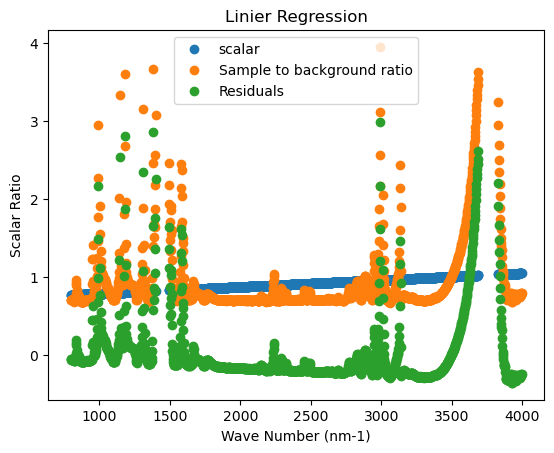

In [9]:
#the following three cells show the progression of the linier regression as it converges. larger data points that dont fit in the range slowly falling
#as we reduce the required root mean squared error we can watch as the data refined converging on a flat line repersenting a scalar
finaldata = findsigdata(data.copy(),.0001)
linierscale(finaldata,background.copy(),.95,1)
#as you can see at .95 there are very large risiduals with ratio and simulated values that have little relation to each other 

The final root mean squared error is 0.04738976052368998


0.7274916498109281

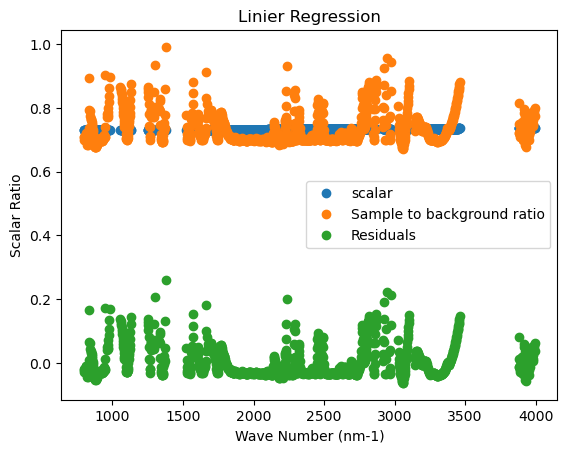

In [10]:
#as soon as .05 you can see a drastic increase in selectivity the line flattening and the very large and disconnected data points removed 
#creating a much clearer trend as the ratio between the background and data in points that are likely only due to background start to immerge
finaldata = findsigdata(data.copy(),.0001)
linierscale(finaldata,background.copy(),.05,1)

The final root mean squared error is 0.003364111172973454


0.7002264976900079

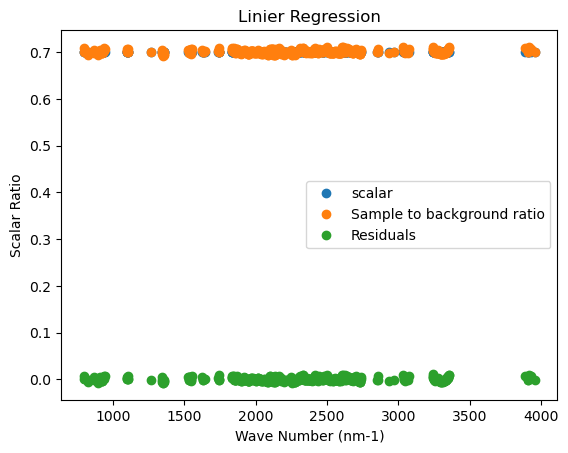

In [11]:
#by the time we get to a lower root mean squared error we have far fewer points painting a clear trend which links the data to the background 
#this gives us a clear indicaton of our scalar as now the ration between our background and the presence of our background in our sample. 
finaldata = findsigdata(data.copy(),.0001)
linierscale(finaldata,background.copy(),.005,1)

The data is computing be not afraid it may take a minute
The final root mean squared error is 0.0009343099977835537
The background scalar ratio was identified to be 0.7008118255368311
there are 15 peaks at the points: 
Point 1 is at position 3750.94923nm-1 With a height of 0.058605539501852155
Point 2 is at position 2831.05063nm-1 With a height of 0.006299687479822274
Point 3 is at position 1668.15994nm-1 With a height of 0.008153476361865392
Point 4 is at position 1583.30556nm-1 With a height of 0.04045122709957254
Point 5 is at position 1511.95074nm-1 With a height of 0.015809446988516357
Point 6 is at position 1481.09461nm-1 With a height of 0.0340833080676693
Point 7 is at position 1461.80952nm-1 With a height of 0.08774577675933265
Point 8 is at position 1427.09637nm-1 With a height of 0.07364972627716247
Point 9 is at position 1382.74067nm-1 With a height of 0.021973999510517622
Point 10 is at position 1313.31436nm-1 With a height of 0.10573548019873921
Point 11 is at position 11

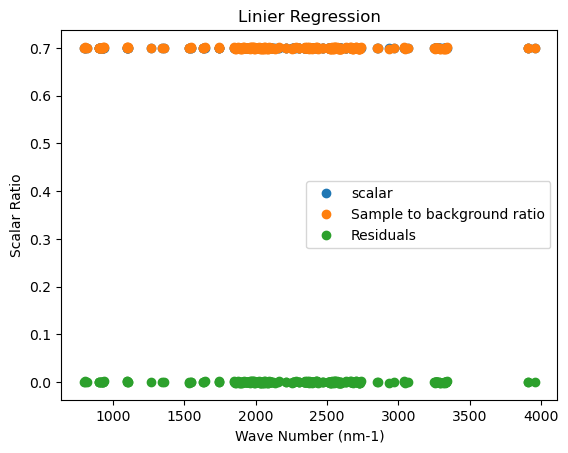

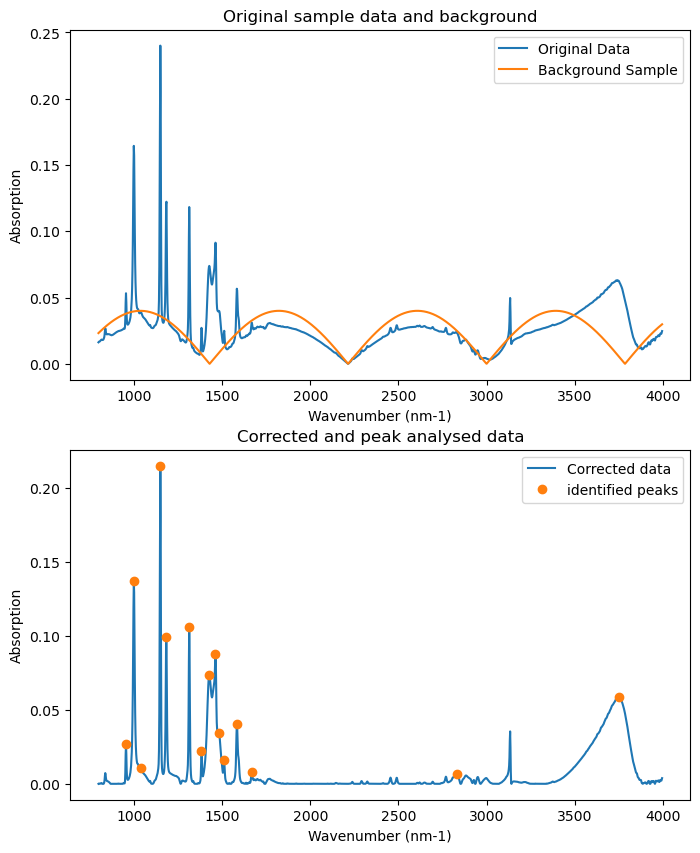

In [13]:
#This is the final section of code intended to be run to process the major data. It uses the various functions established in order to identify the substrate scalar
#and remove the background, resulting in clean data that can be used in further analysis it also has 

#variable selection customizing the various tunable parameters of the data, this has been set to be used with test data set 1, including 
#data file: testdata2.csv 
#background file: testdata2background
#but it can be tuned and run with other data sets, as shown in the related PowerPoint

#range of x values to be considered when finding the scalar selected 
x_range = [-100000,100000]

#variance in y values. i.e., if the data and background dont have identical x values, what range of variance is acceptable? 
#ex if variance is 1, a data point of 3082 nm-1 would be associated with any background value from 3081 nm-1 to 3083 nm-1
variance = 1

# Minimum data value: specifies the minimum y value for which data is considered significant. Used to remove small noise values 
mindata = .0001

# Print specifier: 1 to print raw background-removed data, 2 to print peaks from background-removed data, and 0 for no print.
# Loc name represents the name of the new file you would like to save your data to. 
printer = 1
loc_name = "outputfile.csv"

#root mean squatred error: this specifies what the final goal Root mean square error is. The function will refine the dataset until the error falls below this value
finalerror = .001

#minimum peak: when doing peak finding, what is the smallest y value that can be considered a peak
miny = .003

#minimum slope when looking at a peak what is the minimum slope that indicates an actual increase and not noise
slope = .001

print("The data is computing be not afraid it may take a minute")
data = pd.read_csv(data_file,skiprows=data_header,header = None)
background = pd.read_csv(background_file,skiprows=background_header,header = None)
##print(data)
finaldata = findsigdata(data.copy(),mindata,range=x_range)
scalar = linierscale(finaldata,background,finalerror,variance)
corrected_data = data.copy()
print("The background scalar ratio was identified to be "+str(scalar))
index = 0
indexy = 0
for x in data[0]:
            for n in background[0]:
                if x < n+variance and x>n-variance and index-1<len(data[0]):
                    if data.loc[index,1] - scalar*background.loc[indexy,1] > 0:
                        corrected_data.loc[index,1] = data.loc[index,1] - scalar*background.loc[indexy,1]
                    else:
                        corrected_data.loc[index,1] = 0
                indexy += 1
            index +=1
            indexy = 0
fig, axs = plt.subplots(2,figsize=(8, 10))

axs[0].plot(data[0],data[1],label="Original Data")
axs[0].plot(background[0],background[1],label="Background Sample")
axs[0].set_title("Original sample data and background")
axs[0].set_ylabel("Absorption")
axs[0].set_xlabel("Wavenumber (nm-1)")
axs[0].legend()
axs[1].plot(corrected_data[0],corrected_data[1],label="Corrected data")
axs[1].set_title("Corrected and peak analysed data")
axs[1].set_ylabel("Absorption")
axs[1].set_xlabel("Wavenumber (nm-1)")

peaks = peakfind(corrected_data,min=miny,minslope=slope)
x_points, y_points = zip(*peaks)
##plotting the original data sces are omitted from this because its intended to function with a variety of data types
axs[1].plot(x_points,y_points,'o',label="identified peaks")
axs[1].legend()
ind = 0
for x in x_points:
    print("Point "+str(ind+1)+ " is at position " + str(x)+ "nm-1 With a height of " + str(y_points[ind]))
    ind += 1
if printer == 1:
    corrected_data.to_csv(loc_name,index=False)
elif printer == 2:
    printing = pd.DataFrame(peaks)
    printing.to_csv(loc_name,index=False)
        